In [1]:
# Import packages
from docx import Document
from lxml import etree
import zipfile
import re
import glob
import pandas as pd
import warnings
def custom_formatwarning(msg, *args, **kwargs):
    # ignore everything except the message
    return str(msg) + '\n'

warnings.formatwarning = custom_formatwarning

In [2]:
ooXMLns = {'w':'http://schemas.openxmlformats.org/wordprocessingml/2006/main'}
#Function to extract all the comments of document(Same as accepted answer)
#Returns a dictionary with comment id as key and comment string as value
def get_document_comments(docxFileName):
    comments_dict={}
    docxZip = zipfile.ZipFile(docxFileName)
    commentsXML = docxZip.read('word/comments.xml')
    et = etree.XML(commentsXML)
    comments = et.xpath('//w:comment',namespaces=ooXMLns)
    for c in comments:
        comment=c.xpath('string(.)',namespaces=ooXMLns)
        comment_id=c.xpath('@w:id',namespaces=ooXMLns)[0]
        comments_dict[comment_id]=comment
    return comments_dict

def paragraph_comments(paragraph,comments_dict):
    comments=[]
    for run in paragraph.runs:
        comment_reference=run._r.xpath("./w:commentReference")
        if comment_reference:
            comment_id=comment_reference[0].xpath('@w:id',namespaces=ooXMLns)[0]
            comment=comments_dict[comment_id]
            comments.append(comment)
    return comments

In [103]:

def extract_AI_scores(docxFileName):

    document = Document(docxFileName)
    comments_dict=get_document_comments(docxFileName)
    
    feature_text = []
    category = []
    sub_category = []
    accuracy = []
    event_number = []
    
    event_number_within_loop = []
    
    for para in document.paragraphs:
        # Check if this paragraph contains Event X, if so update event_number_within_loop
        find_event_number = (re.findall(r'\bEvent \d+',para.text))
        if find_event_number:
            event_number_within_loop = [int(s) for s in find_event_number[0].split() if s.isdigit()][0]
            print("Processing Event {}".format(event_number_within_loop))
        
        # Check if paragraph contains a comment
        comm = []
        for run in para.runs:
            comment_reference=run._r.xpath("./w:commentReference")
            if comment_reference:
                comm = comment_reference
        
        # If it does...
        if comm:
    #       Add paragraph text   
            feature_text.append(para.text)

    #       Warn the user if there is an unusually short string
            if len(para.text) < 1:
                warnings.warn("TEXT TOO SHORT. Event: {} Detail: '{}'".format(event_number_within_loop,para.text))

    #       Get comment from this paragraph
            r = paragraph_comments(para,comments_dict)
    #       Add the text to feature_text

    #       Search for pattern of characters

            patt = re.findall(r'[IEie][ETPRSOetprso][VILEHTvileht][TFUtfu]',r[0])

    #       If pattern is found...
            if patt:
                # Warn if length is not 4
                if len(patt[0]) != 4:
                    warnings.warn("WEIRD LENGTH. Event: {} Detail: '{}'".format(event_number_within_loop,para.text))
                
                # Category: I = internal ; E = external
                if patt[0][0].upper() == 'I':
                    text1 = 'internal'
                elif patt[0][0].upper() == 'E':
                    text1 = 'external'
                
                category.append(text1)      
                
                # Sub-Category: EV = event ; PE = perceptual ; TI = time ; PL = Place
                #               TH = thought_emotion ; SE = semantic ; RE = repetition ;
                #               OT = other
                                
                if patt[0][1:3].upper() == 'EV':
                    text2 = 'event'
                elif patt[0][1:3].upper() == 'PE':
                    text2 = 'perceptual'
                elif patt[0][1:3].upper() == 'TI':
                    text2 = 'time'
                elif patt[0][1:3].upper() == 'PL':
                    text2 = 'place'
                elif patt[0][1:3].upper() == 'TH':
                    text2 = 'thought_emotion'
                elif patt[0][1:3].upper() == 'SE':
                    text2 = 'semantic'
                elif patt[0][1:3].upper() == 'RE':
                    text2 = 'repetition'
                elif patt[0][1:3].upper() == 'OT':
                    text2 = 'other'
                else:
                    warnings.warn("WEIRD SUB-CATEGORY PATTERN FOUND. Event: {} Detail: '{}'".format(event_number_within_loop,para.text))
                    text2 = ''
                
                sub_category.append(text2)
                
                # Accuracy: T = true ; F = false ; U = unverifiable
                if patt[0][3].upper() == 'T':
                    text3 = 'true'
                elif patt[0][3].upper() == 'F':
                    text3 = 'false'
                elif patt[0][3].upper() == 'U':
                    text3 = 'unverifiable'
                    
                accuracy.append(text3)
                
                # Add event number
                event_number.append(event_number_within_loop)
                
    #       If pattern is not found make NaNs and create warning...
            else:    
                category.append('NaN')       
                sub_category.append('NaN')
                accuracy.append('NaN')
                event_number.append(event_number_within_loop)

                warnings.warn("PATTERN NOT FOUND. Event: {} Detail: '{}'".format(event_number_within_loop,para.text))
        
        
    # Create data frame
    df = pd.DataFrame(list(zip(event_number,category,sub_category,accuracy,feature_text)),
                   columns =['event_number','category','sub_category','accuracy','text'])

    return df
    
     

In [108]:
df = extract_AI_scores('subjectTEST/test_participant01.docx')

# df = pd.DataFrame(columns=['event_number','category', 
#                             'sub_category','accuracy',
#                             'text'])

# for file in sorted(glob.glob("subjectTEST/*.docx")):
    
#     print(file)
#     df_event = extract_AI_scores(file)
    
#     df = pd.concat([df,df_event],sort=False)



# Print the head
df.head()
df.to_csv('subjectTEST/AIscores.csv')



Processing Event 1
Processing Event 2
Processing Event 21


PATTERN NOT FOUND. Event: 1 Detail: 'This shouldn’t work'


In [107]:
df

,event_number,category,sub_category,accuracy,text
0,1,internal,event,true,"I remember being in the train station,"
1,1,internal,perceptual,true,with big circular old-style archways
2,1,internal,perceptual,true,on the ceiling
3,1,internal,event,true,I walked
4,1,internal,event,false,through the ticket barrier
5,1,internal,event,false,and a women
6,1,internal,event,true,"said hello to me, or welcomed me."
7,1,internal,event,true,Oh and there was an announcement
8,1,internal,event,false,about a train being late or something
9,1,external,other,true,This was right after you said the experiment s...


In [101]:
a = extract_AI_scores('subjectTEST/test_event_02.docx')
print(a[0])

1
['Yes I remember meeting Dave. ', 'He was the tour guide, ', 'And he was very enthusiastic.', 'It was right outside the train station, where we met him.', 'He explained Filbury was a great place, ', 'And there was so much to see and do.', 'I think there might have been cars going past too, ', 'And one honked it’s horn']


WARNING. Event: 1 Detail: 'It was right outside the train station, where we met him.'


In [79]:
df_123.to_csv('1234.csv')


In [71]:
event_number = 

6

In [38]:
df.to_csv('out.csv', index=False)

In [7]:
df['event_num'] = df['event_num'].astype('float')

In [34]:
df_acc   = df[df['accuracy']==1]
df_inacc = df[df['accuracy']==0]

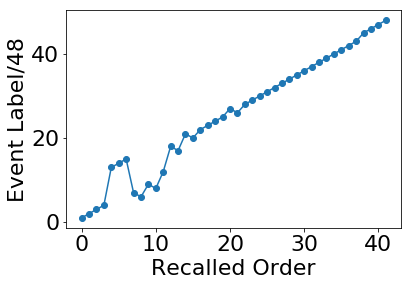

In [63]:
x = df_acc['event_num'].unique()
y = np.arange(0,len(x))
plt.scatter(y,x) 
plt.plot(y,x)
plt.ylabel('Event Label/48')
plt.xlabel('Recalled Order')
plt.savefig('recall_order.png',bbox_inches='tight',dpi=600)
plt.show()


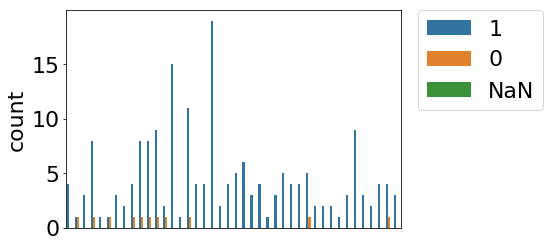

In [76]:
ax = sns.countplot(x="event_num",hue="accuracy", data=df,orient="h")
ax.get_xaxis().set_visible(False)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('accuracy.png',bbox_inches='tight',dpi=600)
plt.show()

In [80]:
diff_vals = np.diff(df_acc['event_num'])
diff_vals = diff_vals[diff_vals!=0]
d = collections.Counter(diff_vals)
d

Counter({-8.0: 1, -3.0: 1, -1.0: 8, 1.0: 30, 2.0: 3, 3.0: 3, 4.0: 3, 9.0: 1})

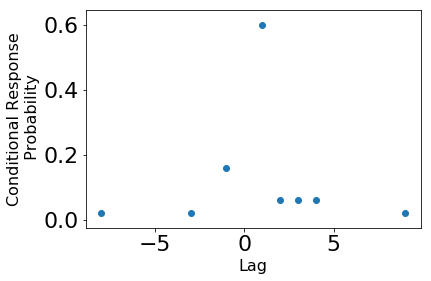

In [106]:
plt.scatter(d.keys(),d.values())
plt.ylabel('Conditional Response\n Probability',FontSize=16)
plt.xlabel('Lag',FontSize=16)
plt.savefig('recall_prob.png',bbox_inches='tight',dpi=600)
plt.show()

In [93]:
d = {k:float(v)/len(diff_vals) for k, v in d.items()}


In [92]:
d.values()/40

SyntaxError: invalid syntax (<ipython-input-92-5fa53a3d3fea>, line 1)

In [ ]:
dict_values